# Data Exploration Project - Datenset Valentinstag

### Beschreibung des Datensets

Der Datensatz ``Valentine's Day Consumer Data`` besteht aus drei csv-Dateien, die Verbraucherverhalten und Ausgabegewohnheiten zum Valentinstag in den USA über ein Jahrzehnt hinweg abbilden. Die Daten stammen von der National Retail Federation (NRF) und umfassen 12 Jahre. 

Das Projekt wurde wegen seiner Relevanz für das Verbraucherverhalten am Valentinstag ausgewählt. Ziel ist es, mit Hilfe von Vorhersagemodellen die Preisentwicklung zu prognostizieren und darauf basierend gezielte Marketingstrategien zu entwickeln. Um die Genauigkeit der Vorhersagen zu optimieren, wird der beste Classifier für diesen Anwendungsfall gesucht. Beim Train-Test-Split wurden die Jahre 2021 und 2022 als Testdaten und alle anderen Jahre als Trainingsdaten festgelegt, um die Vorhersagevalidität zu verbessern.

FYI:
Zu Beginn wurde der Klassifikationsansatz verfolgt, eine Vorhersage zu treffen, ob ein bestimmtes Produkt von einer Frau oder einem Mann gekauft und verschenkt wurde. Dieser Ansatz wurde jedoch verworfen, da die Daten der ``gifts_gender.csv`` als Prozentangaben übergeben werden und die Informationen über die ANzahl der befragten Personen fehlt, um diese Werte in absolute Zahlen zu berechnen.

Die benötigten Bibliotheken werden installiert und in der req.txt abgespeichert.

In [13]:
! pip install -r req.txt

In [14]:
import pandas as pd
import plotly.subplots as sp
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as pltimport 
import joblib
import datetime
import json
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import math


from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve, learning_curve, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error, accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from xgboost import XGBRegressor


In [15]:
df = pd.read_csv('historical_spending.csv')

### Charakterisierung des Datensets

Die Balkendiagramme visualisieren den prozentualen Anteil der Ausgaben für jede Kategorie, unterteilt nach Geschlecht. Das Verständnis der geschlechtsspezifischen Unterschiede bei den Geschenkausgaben kann Händlern dabei helfen, ihre Marketingstrategien zu optimieren und gezielte Werbekampagnen zu entwickeln, die auf die bestimmten Zielgruppen abzielen.

In [16]:
#Stacked Bar Chart

df = pd.read_csv('gifts_gender.csv')
df_percent = df.set_index('Gender').div(df.set_index('Gender').sum(axis=1), axis=0) * 100

fig = go.Figure()

for column in df_percent.columns:
    fig.add_trace(go.Bar(x=df_percent.index, y=df_percent[column], name=column))

fig.update_layout(
    barmode='stack',
    xaxis=dict(title='Gender'),
    yaxis=dict(title='Percentage'),
    title='Percentage of different gifts by gender'
)

fig.show()

print(df.head())

  Gender  SpendingCelebrating  Candy  Flowers  Jewelry  GreetingCards  \
0    Men                   27     52       56       30             37   
1  Women                   27     59       19       14             43   

   EveningOut  Clothing  GiftCards  
0          33        20         18  
1          29        24         24  


Die Pie-Charts zeigen den prozentualen Anteil der Ausgaben für jede Kategorie in verschiedenen Altersgruppen und wie diese sich verteilen. Die Kenntnis der altersspezifischen Ausgabegewohnheiten kann Unternehmen dabei unterstützen, Produkte und Angebote zu entwickeln, die besser auf die Bedürfnisse und Vorlieben verschiedener Altersgruppen abgestimmt sind.

In [17]:
#pie chart

df = pd.read_csv('gifts_age.csv')
df = df.drop(columns=['SpendingCelebrating'])

fig = sp.make_subplots(rows=2, cols=3, subplot_titles=df['Age'].tolist(), specs=[[{'type': 'pie'}, {'type': 'pie'}, {'type': 'pie'}],
                                                                                   [{'type': 'pie'}, {'type': 'pie'}, {'type': 'pie'}]])

for i, age_group in enumerate(df['Age']):
    percentages = df[df['Age'] == age_group].squeeze()[1:]
    fig.add_trace(go.Pie(labels=percentages.index, values=percentages, hole=0.3, name=age_group),
                  row=(i // 3) + 1, col=(i % 3) + 1)

fig.update_layout(title_text='Percentage of gifts by age group', showlegend=False)

fig.show()

Das Liniendiagramm zeigt den zeitlichen Verlauf der Valentinstagsausgaben. Es visualisiert Trends und Veränderungen im Ausgabeverhalten und bei der Feierquote über die Jahre. Durch die Darstellung verschiedener Ausgabenkategorien wird deutlich, welche Geschenke an Beliebtheit gewonnen oder verloren haben. Durch Klicken auf die Legendenlinien können diese im Diagramm ein- oder ausgeblendet werden. 

*Beachtung der Achsenbeschriftung auf beiden Seiten!*

In [18]:
#line diagram

df = pd.read_csv('historical_spending.csv')

fig = go.Figure()

categories = df.columns[2:]
for category in categories:
    fig.add_trace(go.Scatter(x=df['Year'], y=df[category], mode='lines', name=category))

fig.add_trace(go.Scatter(x=df['Year'], y=df['PercentCelebrating'], mode='lines', name='PercentCelebrating', yaxis='y2'))

fig.update_layout(title_text='Historical course of spending behaviour (2010-2022)',
                  xaxis_title='Jahr', yaxis_title='Percentage/expenditure in US dollars',
                  yaxis2=dict(title='Percentage of those celebrating', overlaying='y', side='right', range=[0, 100]),
                  legend=dict(font=dict(size=10), orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1))


fig.show()

Eine gründliche Analyse der Datenqualität ist entscheidend, um sicherzustellen, dass die Ergebnisse zuverlässig und aussagekräftig sind. Die Datenqualität dieses Datensatzes wurde durch mehrere Analysen bewertet, einschließlich der Überprüfung auf fehlende Werte und der Erstellung einer Korrelationsmatrix.

Im Valentinstagsdatensatz sind keine Null-Werte vorhanden, was auf eine sehr gute Datenqualität schließen lässt. Zudem sind alle Werte konsequent im gleichen Format dargestellt, was ihre Interpretation erleichtert. Die Korrelationsmatrix offenbart, dass die Ausgaben für Candy, Flowers, Jewelry sowie Clothing und GiftCards stark miteinander korrelieren. 
Die Datenqualität der anderen Datensets ist recht gut, da dort ebenfalls keine Null-Werte vorhanden sind, die angegebenen Werte jedoch in Prozent angegeben sind und nicht als absolute Werte.

                  Candy   Flowers   Jewelry  GreetingCards  EveningOut  \
Candy          1.000000  0.872253  0.816683       0.539737    0.403856   
Flowers        0.872253  1.000000  0.886656       0.438297    0.488140   
Jewelry        0.816683  0.886656  1.000000       0.398171    0.651477   
GreetingCards  0.539737  0.438297  0.398171       1.000000    0.328747   
EveningOut     0.403856  0.488140  0.651477       0.328747    1.000000   
Clothing       0.929729  0.868605  0.761607       0.463964    0.298995   
GiftCards      0.832338  0.703213  0.719936       0.492484    0.264857   

               Clothing  GiftCards  
Candy          0.929729   0.832338  
Flowers        0.868605   0.703213  
Jewelry        0.761607   0.719936  
GreetingCards  0.463964   0.492484  
EveningOut     0.298995   0.264857  
Clothing       1.000000   0.911497  
GiftCards      0.911497   1.000000  


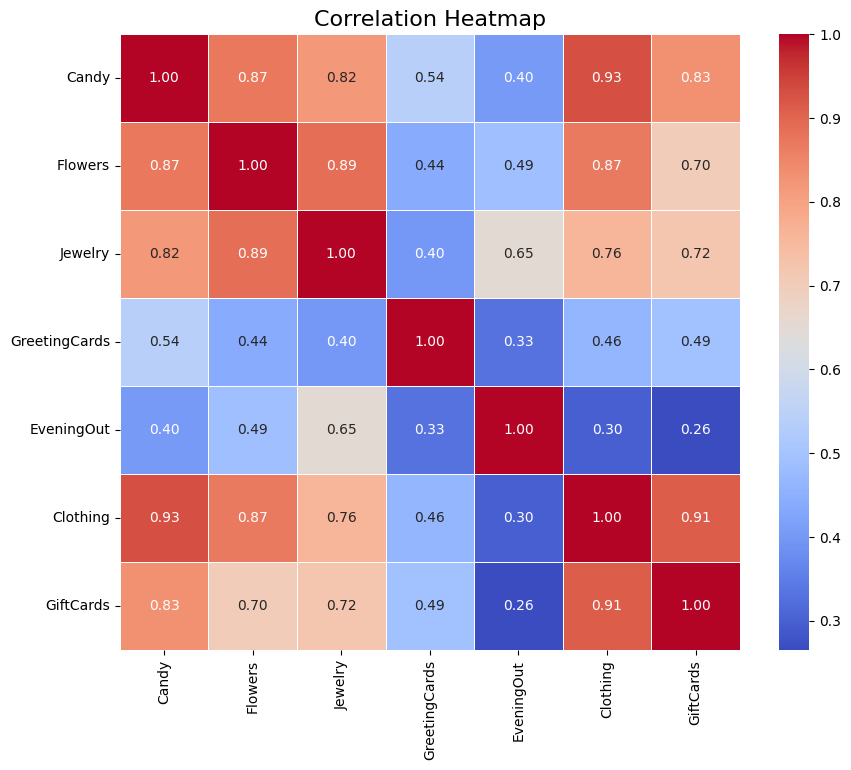

In [56]:
#Correlationmatrix/-heatmap

df = pd.read_csv('historical_spending.csv')

df.drop(['Year', 'PerPerson', 'PercentCelebrating'], axis=1, inplace=True)

correlation_matrix = df.corr()

print(correlation_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap', fontsize=16)
plt.show()

In [20]:
#Verification of data quality

missing_values = df.isnull().sum()

print("Missing values per column:")
print(missing_values)

Missing values per column:
Candy            0
Flowers          0
Jewelry          0
GreetingCards    0
EveningOut       0
Clothing         0
GiftCards        0
dtype: int64


Die Histogrammanalyse bietet Einblicke in die Ausgabenverteilung für verschiedene Produkte im Datensatz. Die Daten sind um einen Mittelwert zentriert und gleichmäßig verteilt, was auf eine ausgewogene Datenverteilung (Normalverteilung) hinweist. Es gibt keine klare Tendenz zur Erhöhung oder Senkung der Durchschnittswerte.

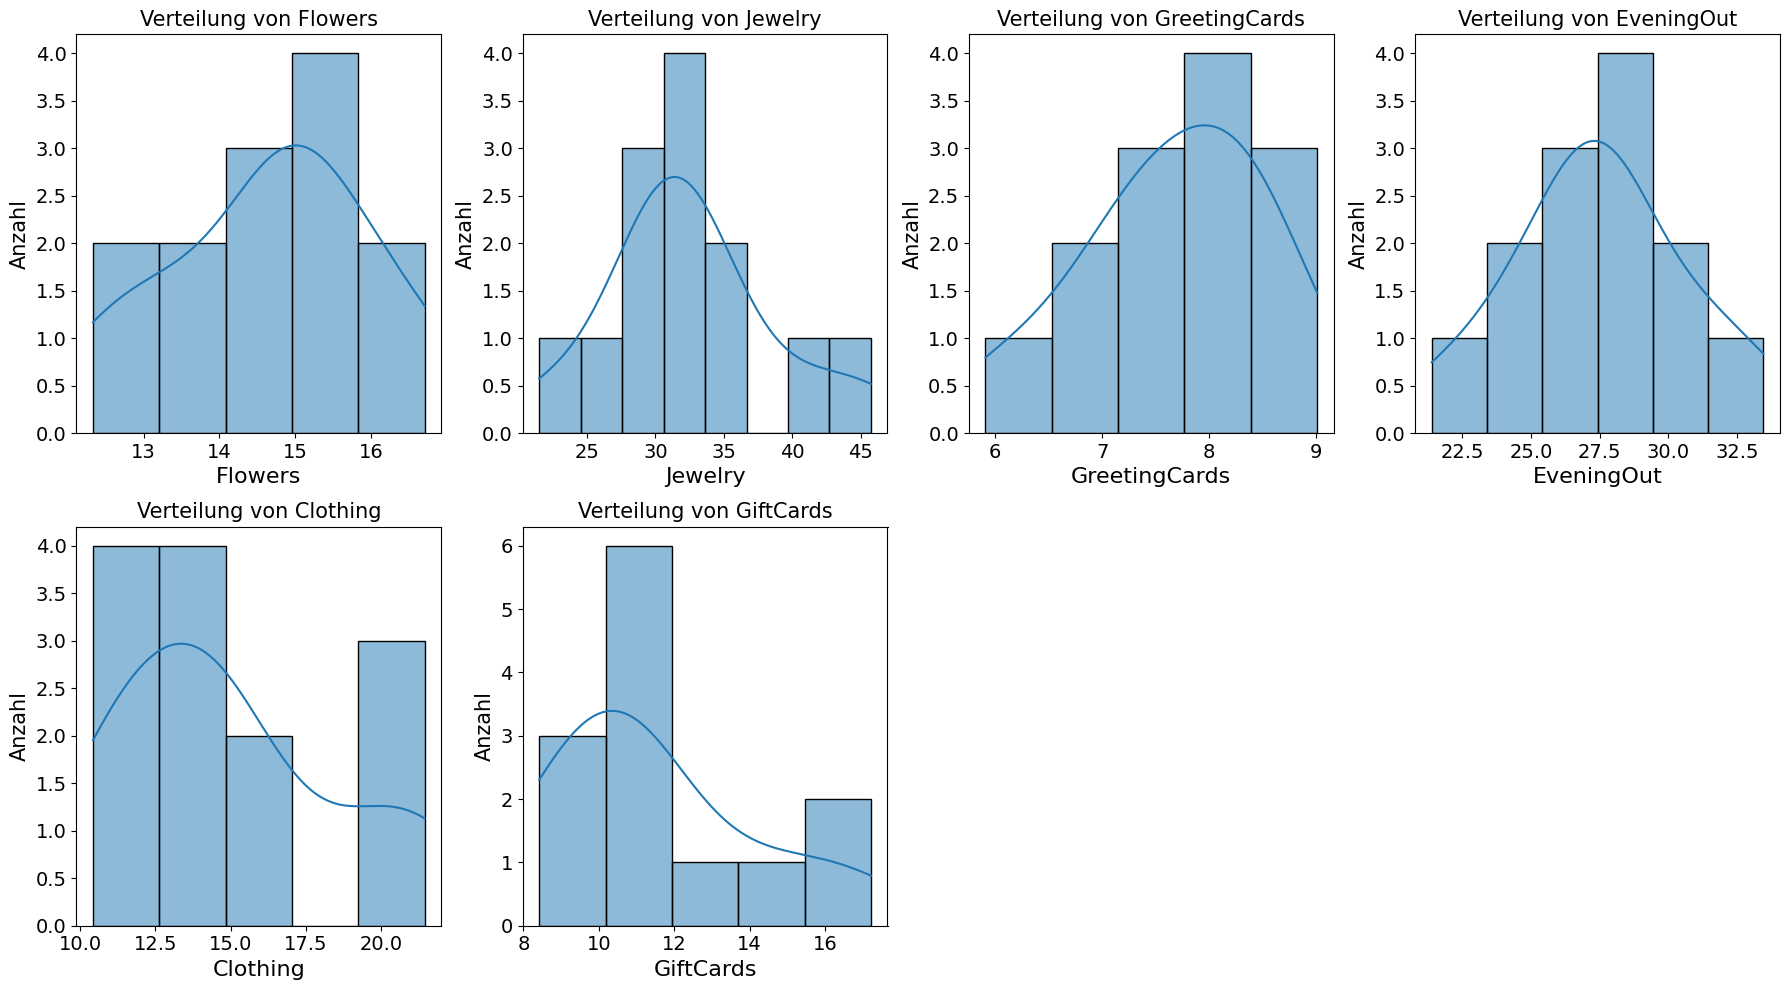

In [62]:
#Histogram analysis

features = df.columns[1:]
num_features = len(features)
num_rows = math.ceil(num_features / 4)
num_cols = min(num_features, 4)

fig, axs = plt.subplots(num_rows, num_cols, figsize=(18, 10))
axs = axs.flatten()

for i, feature in enumerate(features):
    sns.histplot(df[feature], kde=True, ax=axs[i])
    axs[i].set_title(f'Verteilung von {feature}', fontsize=15)
    axs[i].set_xlabel(feature, fontsize=16)  
    axs[i].set_ylabel('Anzahl', fontsize=15)
    axs[i].tick_params(axis='both', which='major', labelsize=14)  
    axs[i].tick_params(axis='both', which='minor', labelsize=9) 

# Verbleibende Subplots entfernen
for j in range(i+1, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()

Der Boxplot dient der Erkennung potenzieller Ausreißer in den Daten. Es wurden keine signifikanten Ausreißer identifiziert. Die Ausgaben für Jewelry sind leicht höher, jedoch nicht signifikant unterschiedlich.

/var/folders/cg/mg68t49x6cd4x_34ppt4f9fr0000gn/T/ipykernel_19120/3476527262.py:9: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/cg/mg68t49x6cd4x_34ppt4f9fr0000gn/T/ipykernel_19120/3476527262.py:10: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



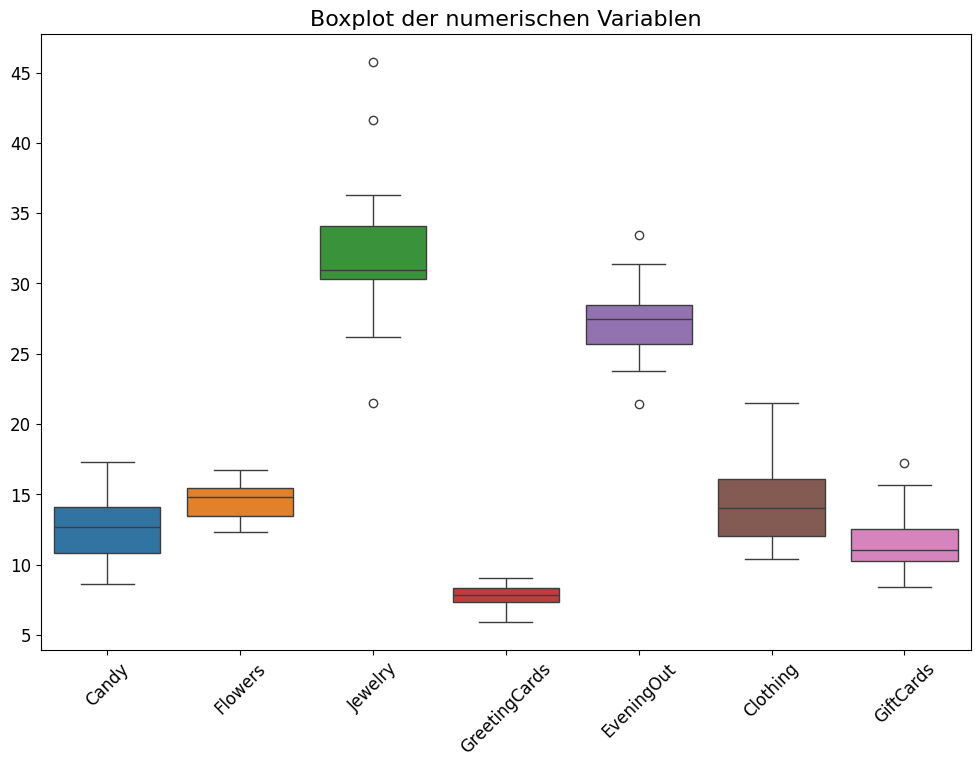

In [64]:
#Representation of strongly deviating elements of the data set

df = pd.read_csv('historical_spending.csv')
df.drop([ 'PerPerson', 'PercentCelebrating'], axis=1, inplace=True)

plt.figure(figsize=(12, 8))
boxplot = sns.boxplot(data=df.drop(['Year'], axis=1))
boxplot.set_title('Boxplot der numerischen Variablen', fontsize=16)  # Schriftgröße für den Titel
boxplot.set_xticklabels(boxplot.get_xticklabels(), fontsize=12)  # Schriftgröße für die X-Achsenbeschriftungen
boxplot.set_yticklabels(boxplot.get_yticklabels(), fontsize=12)  # Schriftgröße für die Y-Achsenbeschriftungen
plt.xticks(rotation=45)
plt.show()

Die historischen Ausgaben von 2010 bis 2022 wurden untersucht und die prozentuale Veränderung zum Vorjahr berechnet. Die Untersuchung der Trends über die Zeit hinweg kann wertvolle Einblicke in die Veränderungen im Verbraucherverhalten und in die Entwicklung der Ausgabenmuster im Laufe der Jahre liefern.

In [23]:
#Table showing the years and the increase in purchasing behaviour
df = pd.read_csv('historical_spending.csv')

df.sort_values(by='Year', inplace=True)

df['PercentChange'] = df['PerPerson'].pct_change() * 100

df_transposed = df.set_index('Year').T.sort_index(ascending=False)

#define style for the table
styles = [
    {'selector': 'tr:nth-of-type(odd)', 'props': 'background-color: #D98D8D; color: #ffffff;'},
    {'selector': 'tr:nth-of-type(even)', 'props': 'background-color: #9D9D9D; color: #ffffff;'},
    {'selector': 'thead th', 'props': 'background-color: #777676; color: #ffffff;'},
    {'selector': 'th, td', 'props': 'border-bottom: 1px solid #100F0F;'},
    {'selector': '', 'props': 'font-family: Arial, sans-serif; font-size: 13px;'},
    {'selector': '', 'props': 'text-align: right;'}
]

df_style = df_transposed.style.set_table_styles(styles).format('{:.2f}')
df_style

Year,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
PercentChange,nan,12.83,8.45,3.92,2.24,6.27,3.18,-6.99,5.12,12.82,21.21,-16.07,6.46
PercentCelebrating,60.00,58.00,59.00,60.00,54.00,55.00,55.00,54.00,55.00,51.00,55.00,52.00,53.00
PerPerson,103.00,116.21,126.03,130.97,133.91,142.31,146.84,136.57,143.56,161.96,196.31,164.76,175.41
Jewelry,21.52,26.18,29.60,30.94,30.58,36.30,33.11,32.32,34.10,30.34,41.65,30.71,45.75
GreetingCards,5.91,8.09,6.93,8.32,7.97,7.87,8.52,7.36,6.55,7.31,9.01,8.48,7.47
GiftCards,8.42,11.21,8.43,10.23,9.00,11.05,12.52,10.23,11.04,10.31,14.21,15.67,17.22
Flowers,12.33,12.62,13.49,13.48,15.00,15.72,14.78,14.63,14.75,15.07,16.49,15.42,16.71
EveningOut,23.76,24.86,25.66,27.93,27.48,27.27,33.46,28.46,26.96,27.72,30.78,21.39,31.35
Clothing,10.93,12.00,10.42,11.46,13.37,14.72,15.05,13.91,14.04,16.08,20.67,20.05,21.46
Candy,8.60,10.75,10.85,11.64,10.80,12.70,13.11,12.68,13.12,14.12,17.30,15.32,15.90


### Logistische Regression

Die Erstellung der logistischen Regression funktioniert hierbei leider nicht, da die zweite Geschlechterklasse der ``gifts_gender.csv`` nicht erkannt wird. Dies ist von Bedeutung, da pro Klasse mindestens zwei Kategorien vorhanden sein müssen. Somit wurde dieser Ansatz nicht weiter verfolgt und sich ein anderer Ansatz herausgesucht. Schließlich wurde dem folgende Ansatz nachgegangen: Eine Vorhersage, die die Entwicklung des Kaufverhaltens anhand der bestehenden Daten für das Jahr 2023 trifft, bestimmen kann. 

### Neuer Projektansatz

Durch die Datensatzgröße birgt zudem das Risiko von Multikollinearität und Overfitting. Deshalb wird die Anwendung eines geeigneten Regressionsmodells, wie lineare Regression, Random Forest Regression sowie der XGBoost verfolgt. Die Interpretation der Vorhersagen werden mit Vorsicht getroffen, da die Genauigkeit aufgrund der geringen Datenmenge eingeschränkt ist.

In [24]:
#load the most important variables for predicting

#load dataset
df = pd.read_csv('historical_spending.csv')

rf = RandomForestRegressor()

#define features and target variables
X = df.drop(['Year', 'PerPerson'], axis=1)
y = df['PerPerson']

#test-/train split (test data only for the years 2021 and 2022)
X_train = X[df['Year'] < 2021]
X_test = X[df['Year'] >= 2021]
y_train = y[df['Year'] < 2021]
y_test = y[df['Year'] >= 2021]

train_data = df[df['Year'] <= 2020].drop(['Year'], axis=1)

test_data_2021 = df[df['Year'] == 2021]

test_data_2022 = df[df['Year'] == 2022]

train_labels = df[df['Year'] <= 2020]['PerPerson']




### RandomForestRegressor

Der RandomForestRegressor wurde wegen seiner Robustheit gegen Overfitting und seiner Anpassungsfähigkeit an kleine Datensätze gewählt. Trotz der begrenzten Datenmenge zeigt der MSE von 0.783 eine moderate Genauigkeit des Modells. Mit einem R² Score von 0.972 werden etwa 97,2% der Variabilität in den 'PerPerson'-Ausgaben erklärt. Zusätzlich zu MSE und R² wurden der Mean Absolute Error und der Root Mean Squared Error als weitere Metriken verwendet.

In [25]:
#RandomForestRegressor model to predict purchasing behavior for the year 2023

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

#metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')


Mean Squared Error: 6.521757800000934
R² Score: 0.770001267826016


In der implementierten RandomForestRegressor-Lösung wird ein GridSearch für die Optimierung der Hyperparameter durchgeführt.  Die Verwendung eines solchen Datensatzes kann die Zuverlässigkeit des GridSearch beeinträchtigen, da der Trainingsdatensatz auf älteren Daten basiert und der Testdatensatz möglicherweise nicht repräsentativ für zukünftige Daten ist. Aufgrund des kleinen Datensatzes und der Hyperparameter-Kombinationen besteht die Gefahr des Overfittings. Die Ergebnisse des GridSearch können instabil sein und stark von der spezifischen Auswahl der Trainings- und Testdaten abhängen. In diesem Fall ist die maximale Baumtiefe 10 aufgrund der begrenzten Trainingsdaten so gering ausgefallen. Ein niedrigerer `min_samples_leaf` sowie `min_samples_split` ermöglicht zwar ein genaueres Modell, kann dazu führen, dass das Modell sich zu stark an die vorhandenen Daten anpasst und die Generalisierungsfähigkeit verliert. Die Modellbewertung basiert auf mehreren Metriken wie MSE, RMSE, R² und MAE. Bei einem kleinen Datensatz können diese Metriken unzuverlässig sein und die tatsächliche Leistung des Modells möglicherweise nicht genau widerspiegeln. Die berechneten Werte werden im ML-Lifecycle Management Report als JSON-Datei gespeichert.

FYI: Die Reports sind in dem Ordner `ML-Lifecycle` zu finden, jedoch wurden die ersten Reports entfernt, da dies in der Menge den Rahmen überschreiten würde.

In [26]:
#RandomForestRegression

param_grid = {
'n_estimators': [50, 100, 200, 250],
    'max_depth': [ 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

#training
grid_search.fit(X_train, y_train)

#print best hyperparameter
best_params = grid_search.best_params_
print(f"Beste Hyperparameter: {best_params}")

timestamp = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
model_filename = f"best_rf_model_{timestamp}.pkl"
joblib.dump(grid_search.best_estimator_, model_filename)
print(f"Bestes Modell wurde als '{model_filename}' gespeichert.")

#model assessment
y_pred = grid_search.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R² Score: {r2}')
print(f'Mean Absolute Error (MAE): {mae}')

report = {
    "Date": timestamp,
    "Model": "RandomForestRegressor",
    "Best Parameters": best_params,
    "Mean Squared Error": mse,
    "Root Mean Squared Error": rmse,
    "R² Score": r2
}

#save report as JSON file
report_filename = f"ml_lifecycle_report_{timestamp}.json"
with open(report_filename, 'w') as f:
    json.dump(report, f)



Fitting 5 folds for each of 144 candidates, totalling 720 fits
Beste Hyperparameter: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Bestes Modell wurde als 'best_rf_model_20240427101826.pkl' gespeichert.
Mean Squared Error (MSE): 1.0216417250004732
Root Mean Squared Error (RMSE): 1.0107629420395632
R² Score: 0.96397040357952
Mean Absolute Error (MAE): 1.0104500000002332


In diesem Abschnitt wird der RandomForestRegressor mit den ermittelten Hyperparametern trainiert und bewertet. Die Vorhersagefunktion ermöglicht Vorhersagen für die Jahre 2021 und 2022 basierend auf den durchschnittlichen Werten der Features für diese Jahre. Aufgrund des kleinen und begrenzten Datensatzes sollten die Vorhersagen und die Modellbewertung mit Vorsicht interpretiert werden. Die ausgegebenen Werte für die Jahre sind sehr ähnlich zu den tatsächlichen Werten, jedoch besteht dennoch ein minimaler Unterschied.

In [27]:
#Hyperparamter tuning with GridSearchCV

param_grid = {
    'n_estimators': [50],
    'max_depth': [10],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}

rf = RandomForestRegressor()
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

grid_search.fit(X, y)

best_params = grid_search.best_params_

rf_best = grid_search.best_estimator_

#prediction function for a specific year
def predict_year(year):
    features = {
        'PercentCelebrating': df[df['Year'] == year]['PercentCelebrating'].mean(),
        'Candy': df[df['Year'] == year]['Candy'].mean(),
        'Flowers': df[df['Year'] == year]['Flowers'].mean(),
        'Jewelry': df[df['Year'] == year]['Jewelry'].mean(),
        'GreetingCards': df[df['Year'] == year]['GreetingCards'].mean(),
        'EveningOut': df[df['Year'] == year]['EveningOut'].mean(),
        'Clothing': df[df['Year'] == year]['Clothing'].mean(),
        'GiftCards': df[df['Year'] == year]['GiftCards'].mean()
    }

    features_df = pd.DataFrame([features])
    prediction = rf_best.predict(features_df)
    
    return prediction[0], features

#prediction 2021
prediction_2021, features_2021 = predict_year(2021)
print(f'\nPrediction for the year 2021: {prediction_2021}')
for feature, value in features_2021.items():
    print(f'{feature}: {value}')

#prediction 2022
prediction_2022, features_2022 = predict_year(2022)
print(f'\nPrediction for the year 2022: {prediction_2022}')
for feature, value in features_2022.items():
    print(f'{feature}: {value}')


Fitting 5 folds for each of 1 candidates, totalling 5 fits

Prediction for the year 2021: 168.41400000000013
PercentCelebrating: 52.0
Candy: 15.32
Flowers: 15.42
Jewelry: 30.71
GreetingCards: 8.48
EveningOut: 21.39
Clothing: 20.05
GiftCards: 15.67

Prediction for the year 2022: 177.38459999999998
PercentCelebrating: 53.0
Candy: 15.9
Flowers: 16.71
Jewelry: 45.75
GreetingCards: 7.47
EveningOut: 31.35
Clothing: 21.46
GiftCards: 17.22


Aufgrund des kleinen Datensatzes und der begrenzten Varianz sind die Vorhersagen möglicherweise nicht repräsentativ für zukünftige Daten. Um die Vorhersagegenauigkeit zu verbessern, sollte der Datensatz mit künstlich generierten Daten erweitert, die Hyperparameter optimiert und verschiedene Szenarien berücksichtigt werden. Für diese Vorhersage wurden Durchschnittswerte für jede Kategorie als Eingabe für das optimierte Modell verwendet.

In [28]:
#prediction 2023

param_grid = {
    'n_estimators': [50],
    'max_depth': [10],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}

best_models = {}

# GridSearch for each label
for label in X.columns:
    y_label = df[label]
    rf = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(rf, param_grid, cv=3)
    grid_search.fit(X, y_label)
    best_models[label] = grid_search.best_estimator_
 
# Predict data for 2023
X_2023 = pd.DataFrame({
    'PercentCelebrating': [53],
    'Candy': [15.9],
    'Flowers': [16.71],
    'Jewelry': [45.75],
    'GreetingCards': [7.47],
    'EveningOut': [31.35],
    'Clothing': [21.46],
    'GiftCards': [17.22],
})

predictions_2023 = {}
for label, model in best_models.items():
    predictions_2023[label] = model.predict(X_2023)


print("\nVorhersagen für 2023:")
for key, value in predictions_2023.items():
    if key != "PerPerson":
        print(f"{key}: {value[0]:.2f}")
    else:
        print(f"{key}: {value:.2f}")


Vorhersagen für 2023:
PercentCelebrating: 52.86
Candy: 15.83
Flowers: 16.51
Jewelry: 43.81
GreetingCards: 7.48
EveningOut: 30.75
Clothing: 20.68
GiftCards: 16.14


Um die Zuverlässigkeit des Modells zu bewerten, wurde die Vorhersage für 2023 mit dem tatsächlichen Wert von 2022 verglichen. Dieser Vergleich zeigt eine nahegelegene Vorhersage, insbesondere für das Label "PerPerson", was die Glaubwürdigkeit des Modells stärkt. Trotz der begrenzten Datenmenge und der festgelegten Hyperparameter scheint das Modell in diesem spezifischen Kontext relativ zuverlässige Vorhersagen zu treffen. Diese Erkenntnisse sollten jedoch kritisch angesehen und bewertet werden. Insbesondere mit Hinblick auf die Vorhersage für das Jahr 2022 gibt einen Eindruck des Overfittings, da der Betrag für das Label `PerPerson` auf den Cent genau vorhergesagt wurde.

In [29]:

rf.fit(X, y)

#compile data for the year 2023
y_2023_actual = df['PerPerson'].iloc[-1]  

#prediction 2023
y_2023_pred = rf.predict(X_2023)

print(f"Prediction for the year 2023 (PerPerson): {y_2023_pred[0]}")
print(f"Actual value for 2022 (PerPerson): {y_2023_actual}")


Prediction for the year 2023 (PerPerson): 174.7046999999999
Actual value for 2022 (PerPerson): 175.41


Bei der Analyse der Feature Importance kann die Zuverlässigkeit der Ergebnisse beeinträchtigt sein, da Overfitting und Datenverzerrung möglich sind. Der Datensatz kann nicht alle relevanten Faktoren und die gesamte Varianz der Daten erfassen, was zu einer eingeschränkten und möglicherweise nicht repräsentativen Bestimmung der Feature Importance führen kann. Um die Genauigkeit und Relevanz der Ergebnisse zu verbessern, sollten der Datensatz erweitert und verschiedene Validierungstechniken angewendet werden.

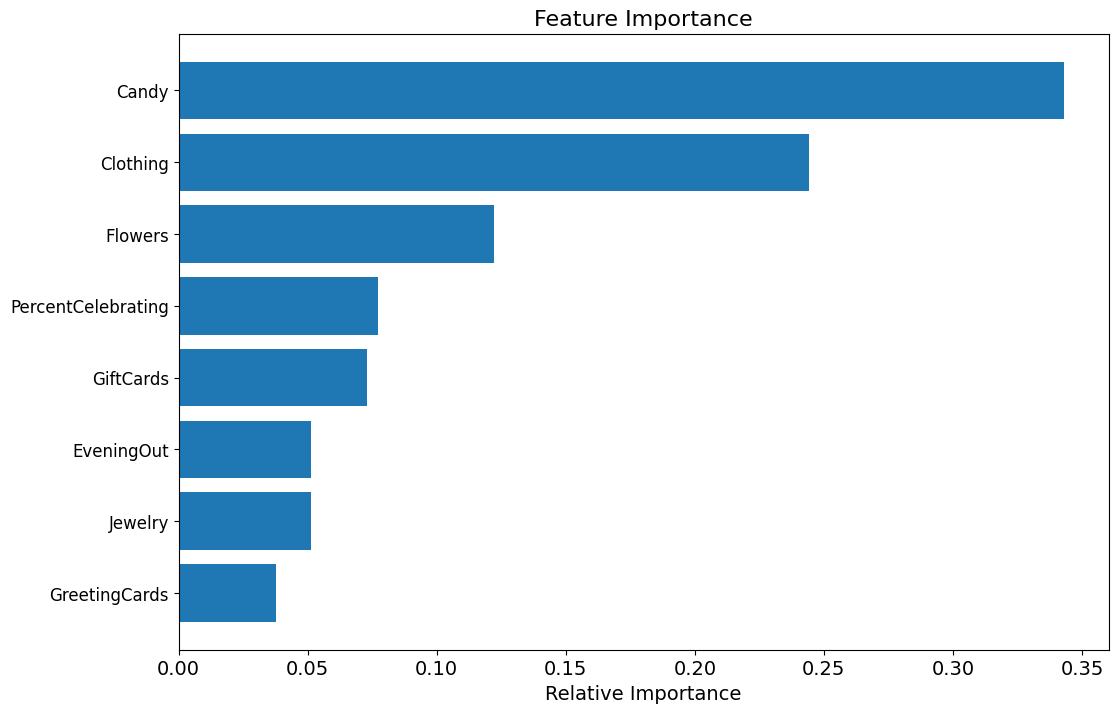

In [67]:
#Feature importance
feature_importances = rf.feature_importances_
features = X.columns
indices = np.argsort(feature_importances)

plt.figure(figsize=(12, 8))
plt.title('Feature Importance', fontsize=16) 
plt.barh(range(len(indices)), feature_importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices], fontsize=12) 
plt.xlabel('Relative Importance', fontsize=14) 
plt.tick_params(axis='x', labelsize=14)
plt.show()

## Lineare Regression

Als weiterer Classifier wurde die lineare Regression getestet, da sie einfacher und weniger anfällig für Overfitting ist, besonders bei einem kleinen Datensatz. Jedoch kann das Vertrauen in die Vorhersage einer linearen Regression eingeschränkt sein, da die Schätzungen der Modellparameter weniger robust und anfälliger für Störungen und Zufallsschwankungen sind

In [31]:
#linear regression

train_data = df[~df['Year'].isin([2021, 2022])]

features = df.columns.drop(['Year', 'PerPerson'])

predictions_2021 = {}
predictions_2022 = {}

for feature in features:
    X_train = train_data.drop(['Year', feature], axis=1)
    y_train = train_data[feature]
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    #prediction 2021
    X_test_2021 = test_data_2021.drop(['Year', feature], axis=1)
    predictions_2021[feature] = model.predict(X_test_2021).tolist()
    
    #prediction 2022
    X_test_2022 = test_data_2022.drop(['Year', feature], axis=1)
    predictions_2022[feature] = model.predict(X_test_2022).tolist()

#linear regression fpr the label "PerPerson"
X_train = train_data.drop(['Year'], axis=1)
y_train = train_data['PerPerson']

model_per_person = LinearRegression()
model_per_person.fit(X_train, y_train)

#Forecast for 2021 and 2022 for 'PerPerson'
X_test_2021 = test_data_2021.drop(['Year'], axis=1)
predictions_2021['PerPerson'] = model_per_person.predict(X_test_2021).tolist()

X_test_2022 = test_data_2022.drop(['Year'], axis=1)
predictions_2022['PerPerson'] = model_per_person.predict(X_test_2022).tolist()

print("Prediction for the year 2021:")
for feature, pred in predictions_2021.items():
    print(f"{feature}: {pred}")

print("\nPrediction for the year 2022:")
for feature, pred in predictions_2022.items():
    print(f"{feature}: {pred}")

Prediction for the year 2021:
PercentCelebrating: [46.420248584683435]
Candy: [14.102934259552267]
Flowers: [14.337367450667905]
Jewelry: [35.709918077165526]
GreetingCards: [7.4203008182867425]
EveningOut: [36.09138564827532]
Clothing: [23.502187208954453]
GiftCards: [12.418162687504257]
PerPerson: [164.76]

Prediction for the year 2022:
PercentCelebrating: [60.10547901322707]
Candy: [17.93571773669972]
Flowers: [17.711857607247445]
Jewelry: [40.869591486760754]
GreetingCards: [11.40418022833487]
EveningOut: [28.266426082163008]
Clothing: [19.357421926141946]
GiftCards: [17.13387059466932]
PerPerson: [175.41]


Die Vorhersage für das Label ``PerPerson``im Jahr 2023 beträgt hierbei 173,97$, was im ersten Moment ein realistischer Wert zu sein scheint. Dies sollte jedoch vorsichtigt betrachtet werden.

In [32]:
#prediction "PerPerson" for 2023

model = LinearRegression()
model.fit(X, y)

X_2023 = df.drop(['Year', 'PerPerson'], axis=1).tail(1)  # Daten für 2022
predictions_2023 = model.predict(X_2023)

print(f'Prediction for the year 2023 (PerPerson): {predictions_2023[0]}')

Prediction for the year 2023 (PerPerson): 173.97412691655498


Die Vorhersage gibt einen groben Überblick über das erwartete Konsumverhalten für 2023 auf Basis der bisherigen Trends und Muster in den Daten. Jedoch kann die Vorhersage ungenau und nicht repräsentativ für zukünftige Entwicklungen sein, da sie auf einem kleinen und begrenzten Datensatz basiert. Dies ist als eine erste Schätzung und grobe Indikation des erwarteten Konsumverhaltens zu sehen.

In [33]:
#prediction consumption behaviour 2023 with linear regression

X = df.drop(['Year'], axis=1)
y = df.drop(['Year'], axis=1)

X = X.iloc[:-1]
y = y.iloc[:-1]

model = LinearRegression()
model.fit(X, y)

X_2023 = df.drop(['Year'], axis=1).tail(1)  # Daten für 2022
predictions_2023 = model.predict(X_2023)

label_names = X.columns

for label, prediction in zip(label_names, predictions_2023[0]):
    print(f'{label}: {prediction}')

PercentCelebrating: 53.00000000000003
PerPerson: 175.41
Candy: 15.899999999999997
Flowers: 16.709999999999997
Jewelry: 45.75000000000007
GreetingCards: 7.470000000000004
EveningOut: 31.350000000000076
Clothing: 21.459999999999976
GiftCards: 17.219999999999978


Trotz eines beeindruckenden R²-Werts von 91% bei der linearen Regression sollte die Vorhersagegenauigkeit mit Vorsicht interpretiert werden, da der hohe Wert durch die spezifischen Eigenschaften und Begrenzungen des kleinen Datensatzes beeinflusst sein kann. Ein hoher R²-Wert kann bei einem kleinen Datensatz leicht erzielt werden und muss nicht unbedingt eine gute Generalisierungsfähigkeit des Modells auf neue, unbekannte Daten bedeuten. Es besteht Verbesserungspotenzial durch Hyperparameter-Tuning und die Berücksichtigung weiterer Modelle und Validierungstechniken.

In [34]:
#cross-validation R²-score

scores = cross_val_score(model, X, y, cv=5)
print(f'Cross-validated R²: {scores.mean():.2f}')

Cross-validated R²: 0.91


## XGBoost Classifier

In [35]:
! pip install xgboost

In [36]:
X = df.drop(['PerPerson', 'Year'], axis=1)
y = df['PerPerson']

model = XGBRegressor(objective ='reg:squarederror')

XGBoost ist ideal für kleine Datensätze, da er robust gegen Overfitting ist und komplexe Beziehungen in den Daten effizient modellieren kann. Der Algorithmus verwendet Entscheidungsbäume mit Regularisierungstechniken, um die Generalisierungsfähigkeit zu verbessern und eine hohe Vorhersagegenauigkeit auch bei begrenzten Datenmengen zu erzielen.

In [37]:
#prediction 2021 and 2022 with XGBoost classifier

train_data = df[~df['Year'].isin([2021, 2022])]

test_data_2021 = df[df['Year'] == 2021]

test_data_2022 = df[df['Year'] == 2022]


# XGBoost-Classifier for each label
predictions_2021 = {}
predictions_2022 = {}

for feature in features:
    X_train = train_data.drop(['Year', feature], axis=1)
    y_train = train_data[feature]
    
    # XGBoost model
    model = xgb.XGBRegressor(objective ='reg:squarederror')
    model.fit(X_train, y_train)
    
    X_test_2021 = test_data_2021.drop(['Year', feature], axis=1)
    predictions_2021[feature] = model.predict(X_test_2021).tolist()

    X_test_2022 = test_data_2022.drop(['Year', feature], axis=1)
    predictions_2022[feature] = model.predict(X_test_2022).tolist()

# XGBoost classifier for label "PerPerson"
X_train = train_data.drop(['Year'], axis=1)
y_train = train_data['PerPerson']

model_per_person.fit(X_train, y_train)

# Forecast for 2021 and 2022 for 'PerPerson'
X_test_2021 = test_data_2021.drop(['Year'], axis=1)
predictions_2021['PerPerson'] = model_per_person.predict(X_test_2021).tolist()

X_test_2022 = test_data_2022.drop(['Year'], axis=1)
predictions_2022['PerPerson'] = model_per_person.predict(X_test_2022).tolist()

print("Prediction for 2021:")
for feature, pred in predictions_2021.items():
    print(f"{feature}: {pred}")

print("\nPrediction for 2022:")
for feature, pred in predictions_2022.items():
    print(f"{feature}: {pred}")



Prediction for 2021:
PercentCelebrating: [53.7770881652832]
Candy: [14.119636535644531]
Flowers: [15.02519416809082]
Jewelry: [32.77590560913086]
GreetingCards: [8.131793975830078]
EveningOut: [27.719974517822266]
Clothing: [16.07979965209961]
GiftCards: [11.083127975463867]
PerPerson: [164.76]

Prediction for 2022:
PercentCelebrating: [54.55305099487305]
Candy: [14.119930267333984]
Flowers: [15.530871391296387]
Jewelry: [35.98004913330078]
GreetingCards: [7.946704864501953]
EveningOut: [27.720102310180664]
Clothing: [16.080005645751953]
GiftCards: [11.424337387084961]
PerPerson: [175.41]


Ein hoher R²-Wert deutet darauf hin, dass das Modell die Daten gut anpasst, jedoch kann dieser Wert bei einem kleinen Datensatz leicht erzielt werden und muss nicht unbedingt eine gute Generalisierungsfähigkeit auf neue Daten bedeuten. Zudem wurdeaufgrund der begrenzten Daten keine separate Validierungsgruppe verwendet, um die Vorhersagegenauigkeit zu überprüfen.

In [38]:
#metrics for 2021 and 2022

predictions_2021 = {}
predictions_2022 = {}

for feature in features:
    X_train = train_data.drop(['Year', feature], axis=1)
    y_train = train_data[feature]
    
    model.fit(X_train, y_train)
    
    X_test_2021 = test_data_2021.drop(['Year', feature], axis=1)
    predictions_2021[feature] = model.predict(X_test_2021)
    
    X_test_2022 = test_data_2022.drop(['Year', feature], axis=1)
    predictions_2022[feature] = model.predict(X_test_2022)

#function to calculate the metrics
def calculate_overall_metrics(true_values, predictions):
    mae = mean_absolute_error(true_values, predictions)
    mse = mean_squared_error(true_values, predictions)
    r2 = r2_score(true_values, predictions)
    return mae, mse, r2

true_values_2021 = test_data_2021[features].values.flatten()
true_values_2022 = test_data_2022[features].values.flatten()

#predictions for 2021 and 2022
all_predictions_2021 = [value for sublist in predictions_2021.values() for value in sublist]
all_predictions_2022 = [value for sublist in predictions_2022.values() for value in sublist]

#metrics for 2021
mae_2021, mse_2021, r2_2021 = calculate_overall_metrics(true_values_2021, all_predictions_2021)
print(f"Metrics für 2021:")
print(f"  MAE: {mae_2021}")
print(f"  MSE: {mse_2021}")
print(f"  R²: {r2_2021}")

#metrics for 2022
mae_2022, mse_2022, r2_2022 = calculate_overall_metrics(true_values_2022, all_predictions_2022)
print(f"\nMetrics für 2022:")
print(f"  MAE: {mae_2022}")
print(f"  MSE: {mse_2022}")
print(f"  R²: {r2_2022}")

Metrics für 2021:
  MAE: 2.5841769981384277
  MSE: 10.75180787849812
  R²: 0.9333046257809142

Metrics für 2022:
  MAE: 3.695557465553284
  MSE: 22.295043625035948
  R²: 0.8996265581775607


Nach dem Vergleich der verschiedenen Classifier zeigte der XGBoost-Algorithmus bereits vor dem Tuning die besten Metrikergebisse. Die hohen R²-Scores von 93,3% für 2021 und 89,9% für 2022 untermauern die Überlegenheit. Aufgrund dieser Ergebnisse wird der XGBoost-Algorithmus als bevorzugtes Modell für zukünftige Analysen verwendet.

### Vorhersage 2023 mithilfe des XGBoost Classifier

Durch die Vorhersage wird der erste Eindruck des Overfittings bestätigt, da ein Wert von 103% für "PercentCelebrating" im Jahr 2023 darauf hin, dass das Modell die Trainingsdaten zu stark anpasst und daher auf neuen, unbekannten Daten eine schlechte Vorhersagegenauigkeit aufweist

In [39]:
#predicition for the year 2023 with train data

model.fit(train_data, train_labels)

predictions_train = model.predict(train_data)

labels = train_data.columns

for label, prediction in zip(labels, predictions_train):
    print(f"{label}: {prediction:.2f}")

Year: 103.00
PercentCelebrating: 116.21
PerPerson: 126.03
Candy: 130.97
Flowers: 133.91
Jewelry: 142.31
GreetingCards: 146.84
EveningOut: 136.57
Clothing: 143.56
GiftCards: 161.96


Hier folgend wird ein angepasster R²-Wert berechnet, da keine genauen Daten für den Abgleich vorhanden sind. Der angepasste R²-Wert berücksichtigt sowohl die Anzahl der Features als auch die Beobachtungen, was ihn zu einer präziseren Metrik macht. Es wird ein angepasster R²-Wert von 1.0 berechnet, was bedeutet, dass etwa 100% der Varianz in den 'PerPerson'-Ausgaben durch die im Modell enthaltenen unabhängigen Variablen erklärt werden können. Dies ist normalerweise eher unwahrscheinlich, sodass das Overfitting bestätigt wird.

In [40]:
# Calculation of the adjusted R² score

predictions_2023_df = pd.DataFrame(predictions_2023)

#number of predictions
n = len(predictions_2023_df)

# Number of independent variables (number of features)
p = predictions_2023_df.shape[1]

#assumed R² score based on scores for 2021 and 2022
r2 = 0.9

adjusted_r2 = 1 - ((1 - r2) * ((n - 1) / (n - p - 1)))

print(f"Adjusted R² score for 2023: {adjusted_r2}")

Adjusted R² score for 2023: 1.0


Die Lernkurve gibt Aufschluss über die Modellleistung in Abhängigkeit von den Trainingsdaten und hilft Overfitting zu erkennen. Ein hoher Trainingsscore deutet auf gute Anpassung an die Daten hin. Der Cross-Validation Score bewertet die Modellleistung auf nicht trainierten Daten. Der Test Cross-Validation Score ist entscheidend für die Bewertung der Vorhersagefähigkeiten auf neuen Daten und zeigt hier einen MSE von mindestens 350, was nicht repräsentativ ist.

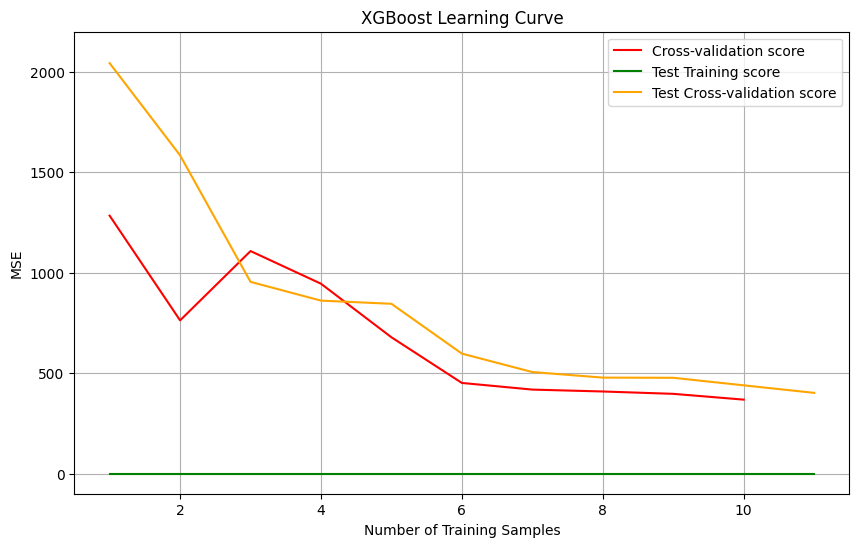

In [41]:
#XGBoost learning curve

X = df.drop(['PerPerson', 'Year'], axis=1)
y = df['PerPerson']

#learning curve for train data
train_sizes, train_scores, test_scores = learning_curve(
    model, X, y, cv=5, scoring='neg_mean_squared_error', 
    train_sizes=np.linspace(0.1, 1.0, 10), shuffle=True, return_times=False)

#means and standard deviations
train_mean = -np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = -np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

#learning curve for test data
test_train_sizes, test_train_scores, test_test_scores = learning_curve(
    model, X, y, cv=8, scoring='neg_mean_squared_error', 
    train_sizes=np.linspace(0.1, 1.0, 10), shuffle=True, return_times=False)

#means and standard deviations
test_train_mean = -np.mean(test_train_scores, axis=1)
test_train_std = np.std(test_train_scores, axis=1)
test_test_mean = -np.mean(test_test_scores, axis=1)
test_test_std = np.std(test_test_scores, axis=1)

plt.figure(figsize=(10,6))
plt.plot(train_sizes, test_mean, label='Cross-validation score', color='red')
plt.plot(test_train_sizes, test_train_mean, label='Test Training score', color='green')
plt.plot(test_train_sizes, test_test_mean, label='Test Cross-validation score', color='orange')


plt.title('XGBoost Learning Curve')
plt.xlabel('Number of Training Samples')
plt.ylabel('MSE')
plt.ylim(-100, 2200)
plt.legend(loc='best')
plt.grid()
plt.show()

Die `GridSearchCV` Funktion wird verwendet, um die Hyperparameter eines XGBoost-Modells automatisch zu optimieren. Durch systematisches durchlaufen aller definierten Hyperparameter-Kombinationen, wie ``gamma``, ``alpha`` und ``reg_lambda``, wird die Kombination gefunden, die die beste Leistung auf den Trainingsdaten erzielt. Dieser Prozess führt zu einer verbesserten Modellleistung, da die Hyperparameter optimal an die Daten angepasst werden, was die Generalisierung auf neue Daten fördert.

In [42]:
#GridSearch XGBoost

param_grid = {
    'gamma': [0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
    'alpha': [0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
    'reg_lambda': [0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=9, scoring='neg_mean_squared_error', n_jobs=-1)

grid_search.fit(train_data, train_labels)

print("Best parameter:", grid_search.best_params_)

Best parameter: {'alpha': 0.4, 'gamma': 0, 'reg_lambda': 1}


Overfitting wird typischerweise durch eine niedrige Trainings-MSE, aber eine hohe Cross-Validation-MSE gezeigt, was hier ebenfalls aufzufinden ist. Der nach dem Grid-Search ebenfalls nicht veränderte angenommene R²-Score von 1.0 bestätigt dies.

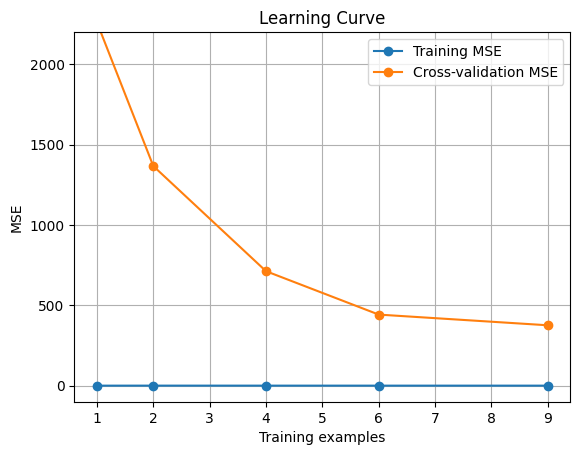

Training MSE for the last training sample: 0.035760113206514316
Cross-Validation MSE for the last training sample: 375.6544618321393
Adjusted R² score for 2023: 1.0


In [43]:
#XGBoost train with regularisation parameters

model = xgb.XGBRegressor(objective='reg:squarederror', 
                         alpha=0.4,
                         gamma=0,            
                         reg_lambda=1)  
model.fit(train_data, train_labels)

train_sizes, train_scores, valid_scores = learning_curve(model, train_data, train_labels, 
                                                          train_sizes=np.linspace(0.1, 1.0, 5), 
                                                          cv=9, scoring='neg_mean_squared_error')

plt.figure()
plt.plot(train_sizes, -train_scores.mean(axis=1), 'o-', label='Training MSE')
plt.plot(train_sizes, -valid_scores.mean(axis=1), 'o-', label='Cross-validation MSE')
plt.xlabel('Training examples')
plt.ylabel('MSE')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.grid()
plt.ylim(-100, 2200)
plt.show()

#calculation MSE
train_mse = -train_scores.mean(axis=1)[-1]
valid_mse = -valid_scores.mean(axis=1)[-1]

print(f"Training MSE for the last training sample: {train_mse}")
print(f"Cross-Validation MSE for the last training sample: {valid_mse}")

predictions_2023 = {
    'PercentCelebrating': [103.0],
    'PerPerson': [116.21],
    'Jewelry': [133.91],
    'GreetingCards': [142.31],
    'GiftCards': [143.56],
    'Flowers': [130.97],
    'EveningOut': [146.84],
    'Clothing': [136.57],
    'Candy': [126.03]
}

predictions_2023_df = pd.DataFrame(predictions_2023)

n = len(predictions_2023_df)

p = predictions_2023_df.shape[1]

r2 = model.score(train_data, train_labels)
adjusted_r2 = 1 - ((1 - r2) * ((n - 1) / (n - p - 1)))

print(f"Adjusted R² score for 2023: {adjusted_r2}")


Zur besseren Interpretation des Modells wurden mehrere Metriken ausgegeben. Das Modell passt sich den Trainingsdaten zu sehr an, wie durch den niedrigen Trainings-MSE bestätigt wird. Jedoch ist der hohe MSE bei der Cross-Validation auffällig, was auf ein Overfitting des Modells hindeutet. Der deutliche Unterschied zwischen Trainings- und Cross-Validation MSE, sowie dem Adjusted R² score von 1.0  bestätigen diese Vermutung des Overfittings.

# Ergebnisdarstellung

### Zusammenfassung des Machine Learning-Projekts zur Vorhersage des Kaufverhaltens am Valentinstag

In diesem Projekt hat der XGBoost-Algorithmus aufgrund seiner hohen Leistung auf den Testdaten von 2021 und 2022 die beste Vorhersage für das Kaufverhalten am Valentinstag gezeigt, da dieser ebenfalls das Modell darstellte, welches am geringsten overfitted ist. Da aufgrund der geringen Datenmenge und der Modellkomplexität Overfitting zu erwarten, was ebenfalls durch die Lernkurve und den (Adjusted) R²-Wert bestätigt werden könnte. Um das Overfitting zu reduzieren, ist die Verwendung von künstlich generierten Daten zur Datensatzerweiterung und die Anpassung der Modellkomplexität erforderlich und zu empfehlen. Trotz der Herausforderungen bietet der XGBoost-Algorithmus großes Potenzial zur weiteren Verbesserung und Überarbeitung dieses Machine-Learning-Projektes. Dadurch kann die Entwicklung gezielter Marketingstrategien zur Maximierung der Umsätze am Valentinstag angestrebt werden.

### Dummy-Regressor

Diese Ergebnisse bestätigt die Vermutung des Overfittings ausdrücklich. Der Vergleich mit dem Dummy-Regressor zeigt, dass mein Modell zwar einen sehr niedrigen Trainingsfehler aufweist, aber Schwierigkeiten hat, auf neuen Daten gut zu generalisieren.
Daraus kann man schließen, dass zusätzliche Regularisierungsmaßnahmen oder ein Modell-Redesign erforderlich sein könnten, um das Overfitting zu reduzieren und die Generalisierungsfähigkeit des Modells für zukünftige Projekte zu verbessern.

In [44]:
#create dummy regressor 
dummy_reg = DummyRegressor(strategy="mean")
dummy_reg.fit(X_train, y_train)

#prediction
y_pred = dummy_reg.predict(X_test)

#print mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error Dummy Regressor : {mse}")


Mean Squared Error Dummy Regressor : 25462.371007024794


### Quellen
https://www.kaggle.com/datasets/joebeachcapital/valentines-day-consumer-data

https://github.com/olgagolban1/DataExploration/settings/access?guidance_task=

In [45]:
#calculation of the word count in the documentation
this_notebook= 'projectml.ipynb'

import json

with open(this_notebook) as json_file:
    data = json.load(json_file)

wordCount = 0
for each in data['cells']:
    cellType = each['cell_type']
    if cellType == "markdown":
        content = each['source']
        for line in content:
            temp = [word for word in line.split() if "#" not in word] # we might need to filter for more markdown keywords here
            wordCount = wordCount + len(temp)
            
print(wordCount)

2045
